In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# 480 × 360
from Parameters import *
import numpy as np
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import glob
import cv2 as cv
import pdb
import pickle
import ntpath
from copy import deepcopy
import timeit
from skimage.feature import hog

In [30]:
params = Parameters()

directory /Users/stimisescu/Coding/ComputerVision/CAVA-2025-TEMA2/saved_files exists 


In [ ]:
with open("./antrenare/daphne_annotations.txt", "r") as f:
    annotations = f.readlines()
    for i in range(len(annotations)):
        annotations[i] = annotations[i].strip().split(' ')
        annotations[i][1:5] = list(map(int, annotations[i][1:5]))
        x1, y1, x2, y2 = annotations[i][1:5]
        width = abs(x2 - x1)
        length = abs(y2 - y1)
        print(f"Annotation {i}: Rectangle width = {width}, length = {length}")

In [11]:
min_width = 9999
min_length = 9999
max_width = -1
max_length = -1
for dir in ["velma", "daphne", "fred", "shaggy"]:
    with open(f"./antrenare/{dir}_annotations.txt", "r") as f:
        annotations = f.readlines()
        for i in range(len(annotations)):
            annotations[i] = annotations[i].strip().split(' ')
            annotations[i][1:5] = list(map(int, annotations[i][1:5]))
            x1, y1, x2, y2 = annotations[i][1:5]
            width = abs(x2 - x1)
            length = abs(y2 - y1)
            min_width = min(width, min_width) if i > 0 else width
            min_length = min(length, min_length) if i > 0 else length
            max_width = max(width, max_width)
            max_length = max(length, max_length)

print(f"Minimum width = {min_width}, Minimum length = {min_length}")
print(f"Maximum width = {max_width}, Maximum length = {max_length}")
# Minimum width = 7, Minimum length = 11

Minimum width = 8, Minimum length = 13
Maximum width = 177, Maximum length = 276


In [21]:
from collections import defaultdict

widths = []
heights = []

# Read all annotations
for dir in ["velma", "daphne", "fred", "shaggy"]:
    with open(f"./antrenare/{dir}_annotations.txt", "r") as f:
        annotations = f.readlines()
        for line in annotations:
            parts = line.strip().split(' ')
            x1, y1, x2, y2 = map(int, parts[1:5])
            width = abs(x2 - x1)
            height = abs(y2 - y1)
            widths.append(width)
            heights.append(height)

# Define bins
bins = [10, 20, 30 ,40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220]
size_distribution = defaultdict(int)

# Assign each rectangle to a bin
for w, h in zip(widths, heights):
    # Find the smallest bin >= size
    w_bin = next((b for b in bins if w <= b), bins[-1])
    h_bin = next((b for b in bins if h <= b), bins[-1])
    size_distribution[(w_bin, h_bin)] += 1

# Print distribution
print("Width x Height -> Count")
for key in sorted(size_distribution.keys()):
    print(f"{key[0]}x{key[1]} -> {size_distribution[key]}")


Width x Height -> Count
10x20 -> 12
10x30 -> 7
10x40 -> 2
10x50 -> 1
20x20 -> 86
20x30 -> 243
20x40 -> 84
20x50 -> 10
20x70 -> 2
20x100 -> 1
30x20 -> 24
30x30 -> 434
30x40 -> 365
30x50 -> 99
30x60 -> 43
30x70 -> 11
30x80 -> 3
30x90 -> 1
30x100 -> 2
30x110 -> 3
30x120 -> 1
40x10 -> 1
40x20 -> 3
40x30 -> 30
40x40 -> 168
40x50 -> 269
40x60 -> 217
40x70 -> 102
40x80 -> 19
40x90 -> 3
40x150 -> 1
50x30 -> 3
50x40 -> 44
50x50 -> 265
50x60 -> 224
50x70 -> 233
50x80 -> 133
50x90 -> 42
50x100 -> 20
50x110 -> 1
50x150 -> 1
60x40 -> 2
60x50 -> 55
60x60 -> 140
60x70 -> 143
60x80 -> 123
60x90 -> 99
60x100 -> 55
60x110 -> 19
60x120 -> 9
60x130 -> 1
60x140 -> 2
70x50 -> 4
70x60 -> 58
70x70 -> 83
70x80 -> 83
70x90 -> 77
70x100 -> 70
70x110 -> 45
70x120 -> 42
70x130 -> 22
70x140 -> 3
70x160 -> 2
80x60 -> 3
80x70 -> 31
80x80 -> 51
80x90 -> 87
80x100 -> 68
80x110 -> 62
80x120 -> 37
80x130 -> 23
80x140 -> 9
80x150 -> 3
80x160 -> 3
80x200 -> 1
90x70 -> 5
90x80 -> 22
90x90 -> 73
90x100 -> 47
90x110 -> 37
90x

In [ ]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np


def visualize_hog_best(
    img_path,
    save_dir="hog_best_visuals",
    cell_size=8,          # 8 or 10 works best for 480×360
    gamma=0.82,           # subtle but effective mid-tone boost
    clahe_clip=2.0,       # gentle local contrast — no over-amplification
    figsize=(14, 7),
    dpi=220
):
    """
    Best practical HOG visualization:
    - Full resolution
    - Gamma + CLAHE only (no Canny, no heavy sharpening)
    - Clean and informative result
    """
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Cannot load {img_path}")
        return

    orig_h, orig_w = img.shape
    print(f"Full resolution: {orig_w}×{orig_h}")

    # === Minimal & effective pre-processing ===
    
    # Gamma correction
    img_gamma = np.power(img / 255.0, gamma) * 255.0
    img_gamma = img_gamma.astype(np.uint8)

    # Gentle CLAHE
    clahe = cv.createCLAHE(clipLimit=clahe_clip, tileGridSize=(8,8))
    img_enhanced = clahe.apply(img_gamma)

    # Normalize (your original step)
    img_final = img_enhanced.astype(np.float32)
    img_final = (img_final - img_final.mean()) / (img_final.std() + 1e-6)
    img_final = np.clip(img_final, -5, 5)

    # Compute HOG
    fd, hog_image = hog(img_final,
                        pixels_per_cell=(cell_size, cell_size),
                        cells_per_block=(2, 2),
                        visualize=True,
                        feature_vector=False)

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.axis('off')
    ax1.imshow(img_final, cmap=plt.cm.gray)
    ax1.set_title(f'Gamma + CLAHE  {orig_w}×{orig_h}')

    ax2.axis('off')
    ax2.imshow(hog_image, cmap=plt.cm.gray)
    ax2.set_title(f'HOG (cell={cell_size})')

    os.makedirs(save_dir, exist_ok=True)
    fname = os.path.basename(img_path)
    save_path = os.path.join(save_dir, f"best_hog_{fname}")
    plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
    plt.close()

    print(f"Saved best HOG visualization: {save_path}")

In [79]:
visualize_hog_best("./antrenare/shaggy/0011.jpg", cell_size=2)

Full res: 480×360
Saved best version: best_0011.jpg


In [ ]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np


def visualize_hog_best(img_path, save_dir="hog_best", cell_size=8):
    """
    Best simple HOG visualization:
    - Full original resolution
    - Gamma + gentle CLAHE only
    - Standard normalization + clip
    - Clean and informative result
    """
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Cannot load {img_path}")
        return

    h, w = img.shape
    print(f"Full resolution: {w}×{h}")

    # 1. Gamma correction — boosts mid-tones (very effective for cartoons)
    gamma = 0.82
    img = np.power(img / 255.0, gamma) * 255.0
    img = img.astype(np.uint8)

    # 2. Gentle CLAHE — local contrast boost without noise
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)

    # 3. Standard normalization (your original)
    img = img.astype(np.float32)
    img = (img - img.mean()) / (img.std() + 1e-6)
    img = np.clip(img, -5, 5)

    # Compute HOG
    fd, hog_image = hog(img,
                        pixels_per_cell=(cell_size, cell_size),
                        cells_per_block=(2, 2),
                        visualize=True,
                        feature_vector=False)

    # Plot side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.axis('off')
    ax1.imshow(img, cmap=plt.cm.gray)
    ax1.set_title(f'Gamma + CLAHE  {w}×{h}')

    ax2.axis('off')
    ax2.imshow(hog_image, cmap=plt.cm.gray)
    ax2.set_title(f'HOG (cell={cell_size})')

    os.makedirs(save_dir, exist_ok=True)
    fname = os.path.basename(img_path)
    save_path = os.path.join(save_dir, f"best_{fname}")
    plt.savefig(save_path, bbox_inches='tight', dpi=220)
    plt.close()

    print(f"Saved best HOG visualization: {save_path}")

In [81]:
visualize_hog_best("./antrenare/shaggy/0011.jpg", cell_size=6)

Full res: 480×360
Saved best version: best_0011.jpg


In [87]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np


def visualize_hog_with_normalization(
    img_path,
    save_dir="hog_comparison",
    cell_size=6,
    window_size=(64, 64),
    with_normalization=True,       # ← toggle to see difference
    title="HOG with/without normalization",
    dpi=200
):
    """
    Visualizes HOG:
    - Load grayscale
    - Resize to window_size (like your pipeline)
    - Optionally apply your exact normalization (mean/std + clip)
    - Compute HOG
    - Show resized patch + HOG side-by-side
    - Saves to disk + shows in notebook if %matplotlib inline
    """
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Cannot load {img_path}")
        return

    orig_shape = img.shape

    # Resize (exactly as in your pipeline)
    img_resized = cv.resize(img, window_size)

    # Optional normalization — same as your current code
    if with_normalization:
        img_processed = img_resized.astype(np.float32)
        std = img_processed.std()
        if std > 1e-6:
            img_processed = (img_processed - img_processed.mean()) / std
            img_processed = np.clip(img_processed, -5, 5)
        else:
            img_processed = img_processed - img_processed.mean()
        norm_title = "resized + normalized"
    else:
        img_processed = img_resized.astype(np.float32)
        norm_title = "resized only (no normalization)"

    # Compute HOG (same params as your pipeline)
    fd, hog_image = hog(
        img_processed,
        pixels_per_cell=(cell_size, cell_size),
        cells_per_block=(2, 2),
        visualize=True,
        feature_vector=False
    )

    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(img_processed, cmap='gray')
    ax1.set_title(norm_title)
    ax1.axis('off')

    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title(f'HOG visualization (cell={cell_size})')
    ax2.axis('off')

    plt.suptitle(f"{title}\nSource: {os.path.basename(img_path)}   |   Orig: {orig_shape}")
    plt.tight_layout()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    fname = os.path.basename(img_path)
    mode = "norm" if with_normalization else "no_norm"
    save_path = os.path.join(save_dir, f"{mode}_hog_{fname}")
    plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
    plt.show()

    print(f"Saved: {save_path}")
    print(f"Descriptor length: {len(fd)}")

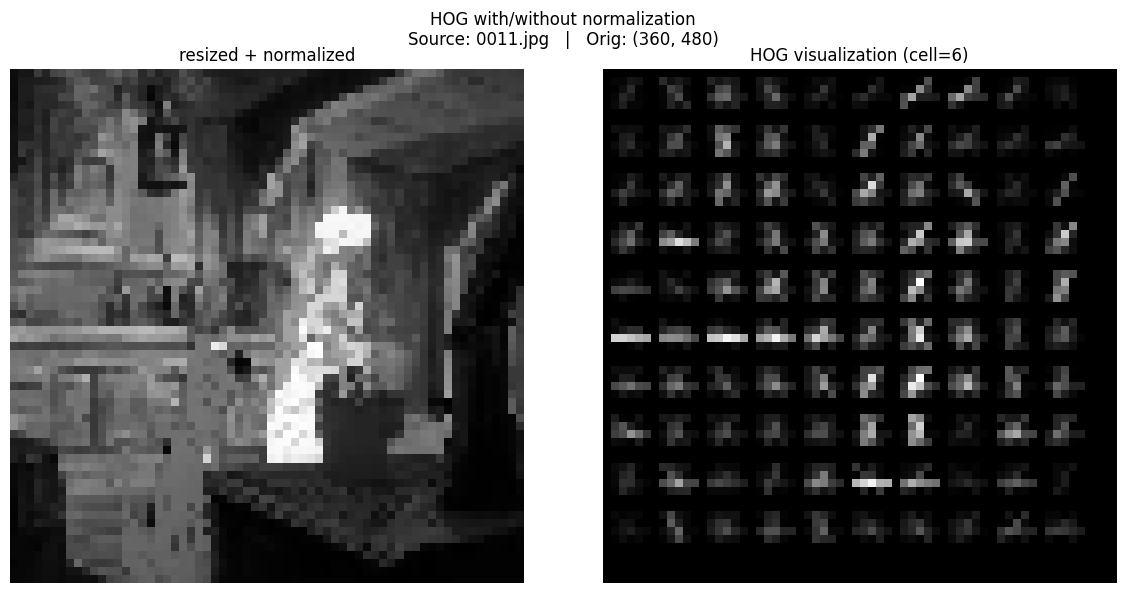

Saved: hog_comparison/norm_hog_0011.jpg
Descriptor length: 9


In [88]:
visualize_hog_with_normalization("./antrenare/shaggy/0011.jpg", cell_size=6, with_normalization=True)

In [89]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np


def visualize_hog_no_normalization(
    img_path,
    save_dir="hog_no_norm",
    cell_size=6,
    window_size=(64, 64),
    title="HOG – no normalization",
    dpi=200
):
    """
    Visualizes HOG exactly as in your current pipeline **without normalization**:
    - Load grayscale
    - Resize to 64×64
    - Only convert to float32 (no mean/std, no clip)
    - Compute HOG
    - Show resized patch + HOG side-by-side
    - Saves to disk + shows inline in notebook
    """
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Cannot load {img_path}")
        return

    orig_shape = img.shape

    # Resize exactly as in your pipeline
    img_resized = cv.resize(img, window_size)

    # No normalization — only type cast to float32 (as in your current normalize_image)
    img_processed = img_resized.astype(np.float32)

    # Compute HOG (same parameters as your code)
    fd, hog_image = hog(
        img_processed,
        pixels_per_cell=(cell_size, cell_size),
        cells_per_block=(2, 2),
        visualize=True,
        feature_vector=False
    )

    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(img_processed, cmap='gray')
    ax1.set_title(f'Resized only (no normalization)\n{window_size}')
    ax1.axis('off')

    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title(f'HOG visualization (cell={cell_size})')
    ax2.axis('off')

    plt.suptitle(f"{title}\nSource: {os.path.basename(img_path)}   |   Orig: {orig_shape}")
    plt.tight_layout()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    fname = os.path.basename(img_path)
    save_path = os.path.join(save_dir, f"no_norm_hog_{fname}")
    plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
    plt.show()

    print(f"Saved: {save_path}")
    print(f"Descriptor length: {len(fd)}")

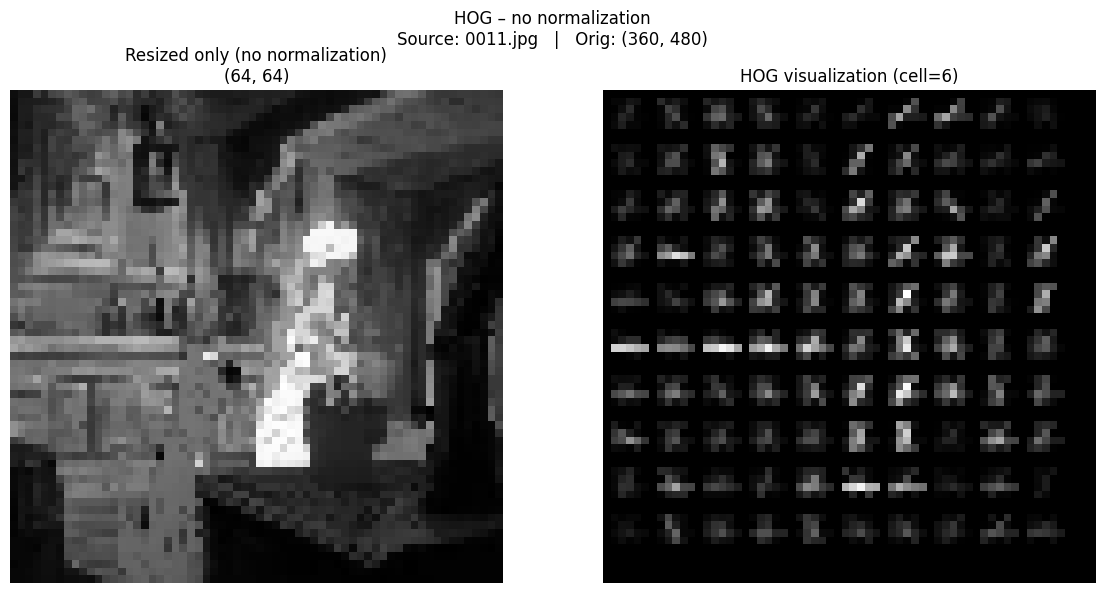

Saved: hog_no_norm/no_norm_hog_0011.jpg
Descriptor length: 9


In [90]:
visualize_hog_no_normalization("./antrenare/shaggy/0011.jpg", cell_size=6)

In [ ]:
from skimage.feature import hog
import matplotlib.pyplot as plt
import os
import cv2 as cv
import numpy as np


def visualize_hog_no_resize(
    img_path,
    save_dir="hog_no_resize",
    cell_size=6,
    with_normalization=True,   # toggle to compare
    title="HOG – no resize",
    dpi=200
):
    """
    Visualizes HOG without resizing the image:
    - Load grayscale
    - Keep full original size (no cv.resize)
    - Optionally apply your current normalization (mean/std + clip)
    - Compute HOG on full image
    - Show processed image + HOG side-by-side
    - Saves to disk + shows inline
    """
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Cannot load {img_path}")
        return

    orig_shape = img.shape
    print(f"Full original resolution: {orig_shape[1]}×{orig_shape[0]}")

    # No resize — use original size
    img_processed = img.copy()

    # Optional: your current normalization
    if with_normalization:
        img_processed = img_processed.astype(np.float32)
        std = img_processed.std()
        if std > 1e-6:
            img_processed = (img_processed - img_processed.mean()) / std
            img_processed = np.clip(img_processed, -5, 5)
        else:
            img_processed = img_processed - img_processed.mean()
        norm_title = "full size + normalized"
    else:
        img_processed = img_processed.astype(np.float32)
        norm_title = "full size only (no normalization)"

    # Compute HOG on full image (may be large/slow for very big images)
    fd, hog_image = hog(
        img_processed,
        pixels_per_cell=(cell_size, cell_size),
        cells_per_block=(2, 2),
        visualize=True,
        feature_vector=False
    )
    exit(0)
    # Display
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

    ax1.imshow(img_processed, cmap='gray')
    ax1.set_title(norm_title)
    ax1.axis('off')

    ax2.imshow(hog_image, cmap='gray')
    ax2.set_title(f'HOG visualization (cell={cell_size}) – full res')
    ax2.axis('off')

    plt.suptitle(f"{title}\nSource: {os.path.basename(img_path)}   |   Orig: {orig_shape}")
    plt.tight_layout()

    # Save
    os.makedirs(save_dir, exist_ok=True)
    fname = os.path.basename(img_path)
    mode = "norm" if with_normalization else "no_norm"
    save_path = os.path.join(save_dir, f"no_resize_{mode}_{fname}")
    plt.savefig(save_path, bbox_inches='tight', dpi=dpi)
    plt.show()

    print(f"Saved: {save_path}")
    print(f"Descriptor length: {len(fd)}")
    print(f"HOG image shape: {hog_image.shape}")

Full original resolution: 480×360


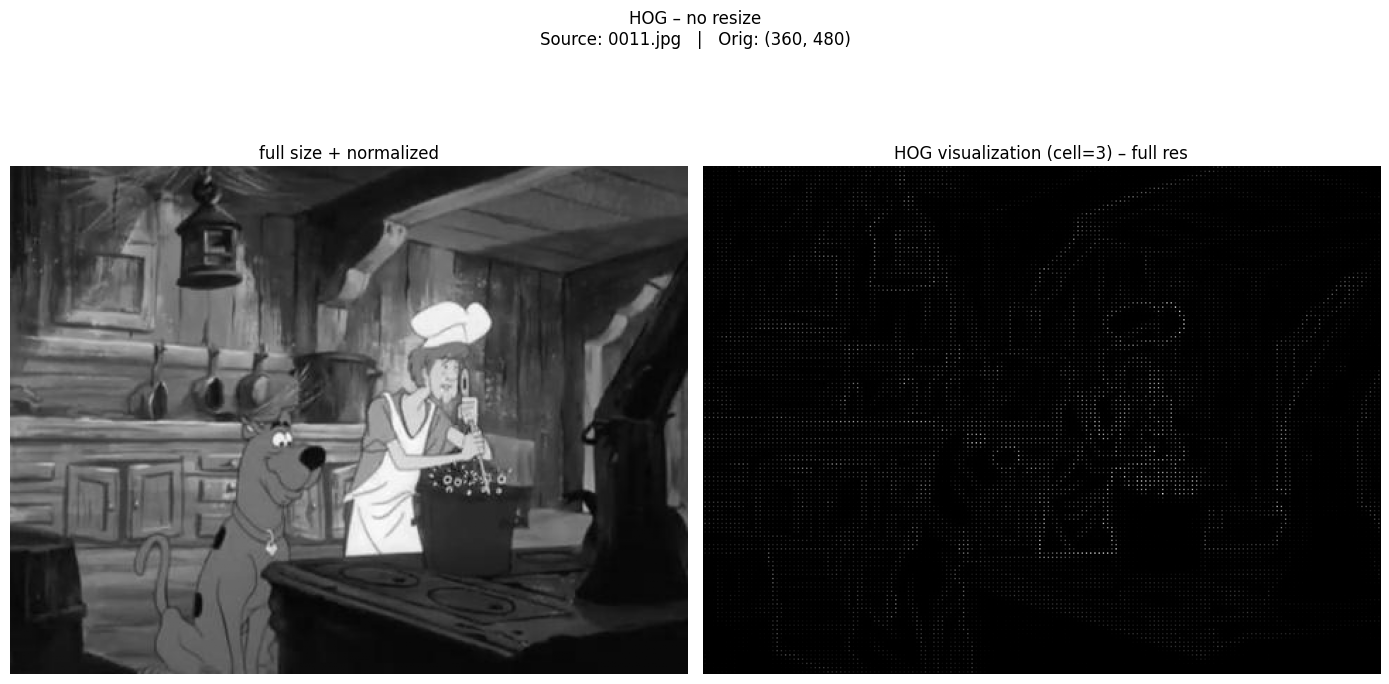

Saved: hog_no_resize/no_resize_norm_0011.jpg
Descriptor length: 119
HOG image shape: (360, 480)


In [101]:
visualize_hog_no_resize(img_path="./antrenare/shaggy/0011.jpg", cell_size=3, with_normalization=True)